In [1]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import *
from keras import optimizers, callbacks
import keras.backend as k 

%matplotlib inline
import matplotlib.pyplot as plt

import sys, math
import pandas as pd
from sklearn import preprocessing 

Using TensorFlow backend.
/home/dani/anaconda3/envs/kerasenvTFGExtractedFeatures/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dani/anaconda3/envs/kerasenvTFGExtractedFeatures/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dani/anaconda3/envs/kerasenvTFGExtractedFeatures/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint1

In [2]:
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K",
        "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U",
        "V", "W", "X", "Y"]
num_classes = len(labels)

data_dir = "Dataset_short_v3"
train_dir = os.path.join(data_dir, "train")
batch_size = 32

# X: features list, Y: class list to predict
X = []
Y = []

# read each folder of train
for label in labels:
    name = os.path.join(train_dir, label, label + ".csv")
    df = pd.read_csv(name)
    X.extend(df.values)
    newSize = len(df)
    print("Letter %s: num_data: %d" %( label, newSize))
    for i in range(0,newSize):
        Y.append(label)
    
# convert to np array to have shape
X = np.array(X)
Y = np.array(Y)

#one hot encoding
lb = preprocessing.LabelBinarizer()
lb.fit(labels)
Y = lb.transform(Y)

Letter A: num_data: 793
Letter B: num_data: 821
Letter C: num_data: 966
Letter D: num_data: 585
Letter E: num_data: 918
Letter F: num_data: 628
Letter G: num_data: 70
Letter H: num_data: 31
Letter I: num_data: 698
Letter K: num_data: 641
Letter L: num_data: 810
Letter M: num_data: 283
Letter N: num_data: 285
Letter O: num_data: 626
Letter P: num_data: 22
Letter Q: num_data: 11
Letter R: num_data: 544
Letter S: num_data: 546
Letter T: num_data: 260
Letter U: num_data: 595
Letter V: num_data: 768
Letter W: num_data: 818
Letter X: num_data: 347
Letter Y: num_data: 770


In [3]:
sizeX = len(X)
sizeY = len(Y)
print(X.shape, Y.shape)

(12836, 42) (12836, 24)


In [4]:
#split into training,val data. test_data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.05)


In [5]:
print("train data ", X_train.shape, Y_train.shape)
print("val data ", X_val.shape, Y_val.shape)
print("test data ", X_test.shape, Y_test.shape)

#handle unbalance data 
Y_train_classes = lb.inverse_transform(Y_train)
len(Y_train_classes)
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(Y_train_classes),
                                                 Y_train_classes)
class_weight_dic = dict(enumerate(class_weights))

train data  (11584, 42) (11584, 24)
val data  (610, 42) (610, 24)
test data  (642, 42) (642, 24)


/home/dani/anaconda3/envs/kerasenvTFGExtractedFeatures/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S'
 'T' 'U' 'V' 'W' 'X' 'Y'], y=['E' 'U' 'O' ... 'F' 'X' 'O'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [42]:
X_train??

In [6]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(42,)))
#model.add(Dropout(0.01))
model.add(Dense(num_classes))
model.add(Activation("softmax"))

In [7]:
model.summary()
model.compile(optimizer=optimizers.SGD(lr=0.01), loss="categorical_crossentropy",
                  metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1376      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                792       
_________________________________________________________________
activation_1 (Activation)    (None, 24)                0         
Total params: 2,168
Trainable params: 2,168
Non-trainable params: 0
_________________________________________________________________




In [8]:
#history = model.fit(X_train, Y_train, batch_size=32, epochs=5, validation_data=(X_val, Y_val))
checkpoint_dir = "checkpointsASLFeaturesShortV3/"
checkpoint_name = (checkpoint_dir
    + "featuresShortV3-{val_loss:.4f}-{val_acc:.4f}.hdf5")
 
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
 
def create_callbacks():
    return [
        callbacks.EarlyStopping(
            monitor="val_acc",
            patience=15,
            verbose=1),
        callbacks.ModelCheckpoint(
            checkpoint_name,
            monitor="val_acc",
            verbose=1,
            save_best_only=True),
    ]
 
my_callbacks = create_callbacks()
histories = []

In [11]:
#finetuning
K.set_value(model.optimizer.lr,
                K.get_value(model.optimizer.lr) / 2)

histories.append(model.fit(
    X_train, 
    Y_train, 
    batch_size=batch_size, 
    epochs=20, 
    validation_data=(X_val, Y_val),
    callbacks=my_callbacks,
    class_weight=class_weight_dic))

Train on 11584 samples, validate on 610 samples
Epoch 1/20
11584/11584 [==============================] - 0s 31us/step - loss: 0.2661 - acc: 0.9407 - val_loss: 0.2397 - val_acc: 0.9475

Epoch 00001: val_acc did not improve from 0.95246
Epoch 2/20
11584/11584 [==============================] - 0s 33us/step - loss: 0.2655 - acc: 0.9415 - val_loss: 0.2412 - val_acc: 0.9475

Epoch 00002: val_acc did not improve from 0.95246
Epoch 3/20
11584/11584 [==============================] - 0s 38us/step - loss: 0.2648 - acc: 0.9403 - val_loss: 0.2398 - val_acc: 0.9459

Epoch 00003: val_acc did not improve from 0.95246
Epoch 4/20
11584/11584 [==============================] - 0s 31us/step - loss: 0.2645 - acc: 0.9422 - val_loss: 0.2424 - val_acc: 0.9443

Epoch 00004: val_acc did not improve from 0.95246
Epoch 5/20
11584/11584 [==============================] - 0s 32us/step - loss: 0.2642 - acc: 0.9402 - val_loss: 0.2413 - val_acc: 0.9459

Epoch 00005: val_acc did not improve from 0.95246
Epoch 6/20
1

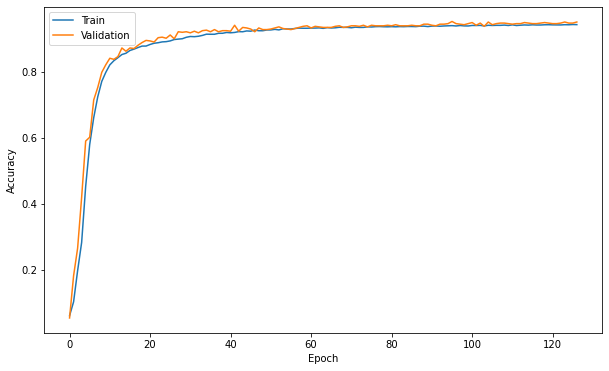

In [12]:
def combine_histories():
  history = {
      "loss": [],
      "val_loss": [],
      "acc": [],
      "val_acc": []
  }

  for h in histories:
      for k in history.keys():
          history[k] += h.history[k]
  return history

history = combine_histories()

def plot_accuracy(history):
  fig = plt.figure(figsize=(10, 6))
  plt.plot(history["acc"])
  plt.plot(history["val_acc"])
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(["Train", "Validation"])
  plt.show()

plot_accuracy(history)

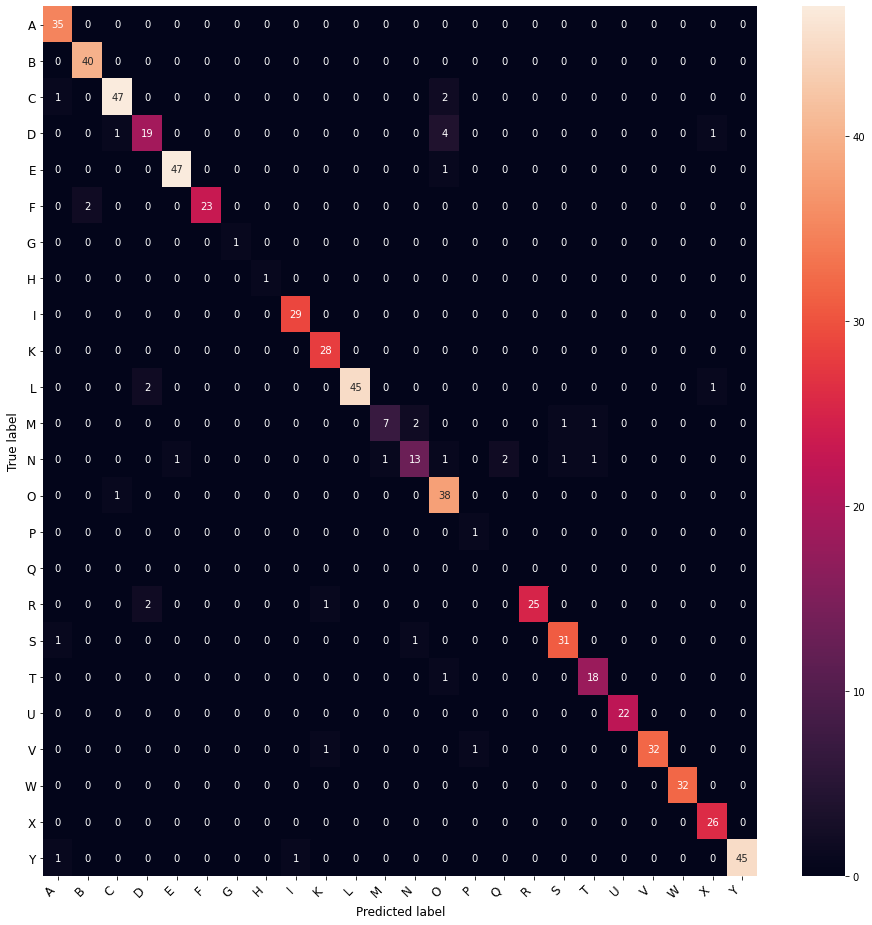

In [13]:
### test model 
#model.evaluate(X_test, Y_test)

#get test data in format
probabilities = model.predict(X_test)
predicted_labels = np.argmax(probabilities, axis=-1)

target_labels_classes = lb.inverse_transform(Y_test)

#obtein index of class
le = preprocessing.LabelEncoder()
le.fit(labels)
target_labels = le.transform(target_labels_classes)

from sklearn import metrics
conf = metrics.confusion_matrix(target_labels, predicted_labels)

import seaborn as sns

def plot_confusion_matrix(conf, labels, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(conf, annot=True, fmt="d")
    heatmap.xaxis.set_ticklabels(labels, rotation=45,
                                 ha="right", fontsize=12)
    heatmap.yaxis.set_ticklabels(labels, rotation=0,
                                 ha="right", fontsize=12)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.show()

    

plot_confusion_matrix(conf, labels, figsize=(16, 16))

In [13]:
#metricas
print(metrics.classification_report(target_labels, predicted_labels, target_names=labels))

wrong_letters = np.where(predicted_labels != target_labels)[0]
probs_max = np.max(probabilities, axis=-1)
idx = np.argsort(probs_max[wrong_letters])
idx = idx[::-1][:5]
worst_predictions = wrong_letters[idx]
worst_predictions

worst_predictions 

for i in worst_predictions:
    print("was predicted as %s  %.4f" % (
            predicted_labels[i],
            probs_max[i]
    ))

ValueError: Number of classes, 23, does not match size of target_names, 24. Try specifying the labels parameter

In [14]:
import coremltools
from keras.models import load_model

In [15]:
best_model = load_model(checkpoint_dir + "featuresShortV3-0.2536-0.9525.hdf5")

In [16]:
coreml_model = coremltools.converters.keras.convert(
        best_model,
        input_names="handpoint",
        output_names="labelProbability",
        predicted_feature_name="label",
        class_labels=labels)

# add metadata to the model
coreml_model.author = "Daniel"
coreml_model.license = "Public"
coreml_model.short_description = "Hand points classifier for 24 different letters of ASL"

coreml_model.input_description["handpoint"] = "normalized coordinates for hand points"
coreml_model.output_description["labelProbability"]= "Prediction probabilities"
coreml_model.output_description["label"]= "Class label of top prediction"

coreml_model.save("ASLHandPointShortV3.mlmodel")

0 : dense_1_input, <keras.engine.input_layer.InputLayer object at 0x7f79c90db0f0>
1 : dense_1, <keras.layers.core.Dense object at 0x7f79c90db0b8>
2 : dense_1__activation__, <keras.layers.core.Activation object at 0x7f7a001b8278>
3 : dense_2, <keras.layers.core.Dense object at 0x7f79c90db4e0>
4 : activation_1, <keras.layers.core.Activation object at 0x7f79c90e5208>


In [1]:
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K",
        "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U",
        "V", "W", "X", "Y"]
num_classes = len(labels)

In [2]:
num_classes

24

In [17]:
dict(enumerate(class_weights))

{0: 1.1571888412017168,
 1: 1.243393047179851,
 2: 1.1893875127248048,
 3: 1.1514865308804205,
 4: 1.1499753937007875,
 5: 0.9151762402088773,
 6: 0.4776676206050695,
 7: 0.5738580550098232,
 8: 0.985693194600675,
 9: 1.0207119976703554,
 10: 0.8778174305033809,
 11: 0.7334431889516635,
 12: 0.735598111227702,
 13: 1.140619915392125,
 14: 14.6046875,
 15: 6.613443396226415,
 16: 1.2527251608291636,
 17: 1.0909197012138188,
 18: 0.5263740801922211,
 19: 1.3347772277227723,
 20: 1.2132658359293873,
 21: 1.1687645881960653,
 22: 1.1797795355099294,
 23: 1.0204148471615722}